Tommaso Peritore

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import contextily as ctx

import numpy as np

%config InlineBackend.figure_format = 'retina'

# Exercise 10

## 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

## Solution

I chose to implement the first possibility. I parallelized the Genetic Algorithm code using MPI libraries in order to solve the TSP by performing a Genetic Search with $4$ parallel GA searches of the optimal path. Each node performs an independent GA search, the so-called Continent, and every $N_{migr}$ generations the Continents exchange their best individuals randomly.

### Code description
Starting from the code created for exercise 9, most of the changes to be made where in the `main.cpp` file. Here I added the MPI initialization and constructed a way to let the nodes communicate with each other every $N_{migr}$ generations. 

Each node has its own instance of the `TSP` class and performs the GA search through the `tsp.evolution()` function. Once every $N_{migr}$ generations, all nodes collect their best element in the variable `migrator`. Then, all nodes send their `migrator` to rank 0, which collects them in a matrix through the `MPI_Gather` function. Rank 0 then reshuffles the order in which the elements appear in the matrix and sends it back to all nodes with `MPI_Bcast`. Each node then updates its best travel chosing the element in the column of the matrix corresponding to its rank. The two functions used here, tsp.get_best_travel() and tsp.set_best_travel(), are written specifically for the parallelization of the code but are pretty self-explanatory. Here I show the part of the main where the migration is implemented:

```cpp
if ( tsp.get_migration() and !(gen % migration_step) and gen != 0){
  
  migrator = tsp.get_best_travel() ;

  // all nodes send to rank 0 their best travel
  MPI_Barrier(MPI_COMM_WORLD);
  MPI_Gather(migrator.memptr(), migrator.size(), MPI_INTEGER, migrators_mat.memptr(), migrator.size(), MPI_INTEGER, 0, MPI_COMM_WORLD);
  
  if (rank == 0) migrators_mat = arma::shuffle(migrators_mat, 1);
  
  // now they all get the reshuffled matrix
  MPI_Barrier(MPI_COMM_WORLD);
  MPI_Bcast(migrators_mat.memptr(), migrators_mat.size(), MPI_INTEGER, 0, MPI_COMM_WORLD);
  
  // each rank now has the whole matrix, the coloumn corresponding to its rank is its new given best travel
  migrator = migrators_mat.col(rank);
  tsp.set_best_travel(migrator); 
}
```

### Execution
To facilitate execution, specifically to allow easy testing of the code, I added a new parameter to the input file, always found in `./10.1/INPUT/input.dat`: `MIGRATION_STEP`, which sets the number of generations between each migration. For all executions I kept this to $N_{migr}=5$. Additionally, now the `TSP_TYPE` parameter has $2$ inputs: the first sets the behaviour of the generation of cities, i.e. "Square", "Circle", or "Provinces", where the last was added to handle the next part of the exercise. The second input sets wether we will make migrations during the search. These parameters are especially used to chose the output directory of the results, to collect and organize our data.

### Results

## 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## Solution

In [84]:
def plot_cap_coords(ax):
	# Load the world map
	world = gpd.read_file('./10.1/INPUT/MAP/ne_110m_admin_0_countries.shp')
	country_name_column = 'NAME'  # Adjust this to the actual column name
	# Select a country (e.g., Italy)
	country_name = 'Italy'
	country = world[world['ADMIN'] == country_name]
	points = np.loadtxt("./10.1/INPUT/cap_prov_ita.dat", usecols=(0, 1))
	# Create a GeoDataFrame for the points
	geometry = [Point(xy) for xy in points]
	geo_df = gpd.GeoDataFrame(geometry=geometry)
	# Plot the map
	country.plot(ax=ax, color='lightgray')
	geo_df.plot(ax=ax, color='red', markersize=50)

def open_data_generations(type, migration, gen, rank):
	
	 # type = "Circle", "Square", "Provinces"
	 # migration = "yes", "no"
	 # gen = generation number
	 # rank = rank of the individual
	
	# Path to the folder
	folder_path = "./10.1/OUTPUT/" 
	if type == "Circle":
		folder_path += "CIRCLE/"
	elif type == "Square":
		folder_path += "SQUARE/"
	elif type == "Provinces":
		folder_path += "PROVINCES/"

	if migration == "no":
		folder_path += "INDEPENDENT_SEARCH/"
	else:
		folder_path += "MIGRATIONS/"
	
	# Read the fittest.dat file and split it into generations
	with open(folder_path + "rank" + str(rank) + "_fittest.dat", "r") as f:
		next(f)  # Skip the first line
		data = f.read().strip().split("\n\n")

	# Load data from file for cities
	int_values, x_values, y_values = np.loadtxt(folder_path + "cities_details.dat", usecols=(0, 1, 2), unpack=True)
	int_values = int_values.astype(int)  # Convert the first column to integers

	fig, ax = plt.subplots(figsize=(10, 10))
	
	# Plot the points from cities_details.dat
	ax.scatter(x_values, y_values, color='black', s=10)
	
	if type == "Circle":
		theta = np.linspace(0, 2 * np.pi, 100)
		x_c = np.cos(theta)
		y_c = np.sin(theta)
		ax.plot(x_c, y_c, c='lightcoral')
	elif type == "Square":
		ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], c='red')
	elif type == "Provinces":
		plot_cap_coords(ax)
	
	# Extract travel indices for the specified generation
	travel_indices = np.array(data[gen].strip().split(), dtype=int)
	
	# Plot the travel route by connecting each point with a line
	for i in range(len(travel_indices) - 1):
		start_index = travel_indices[i]
		end_index = travel_indices[i + 1]
		ax.plot([x_values[start_index], x_values[end_index]], [y_values[start_index], y_values[end_index]], color='grey', alpha=0.7)

	# Add labels to each point
	for i, txt in enumerate(int_values):
		ax.annotate(txt, (x_values[i], y_values[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

	# Set labels and title
	ax.set_xlabel('Longitude')
	ax.set_ylabel('Latitude')
	ax.grid(True)
	ax.set_title('Best route generation ' + str(gen))

	# Set fixed aspect ratio
	ax.set_aspect('equal', adjustable='box')

	plt.show()
	plt.close()
	
	return len(data)


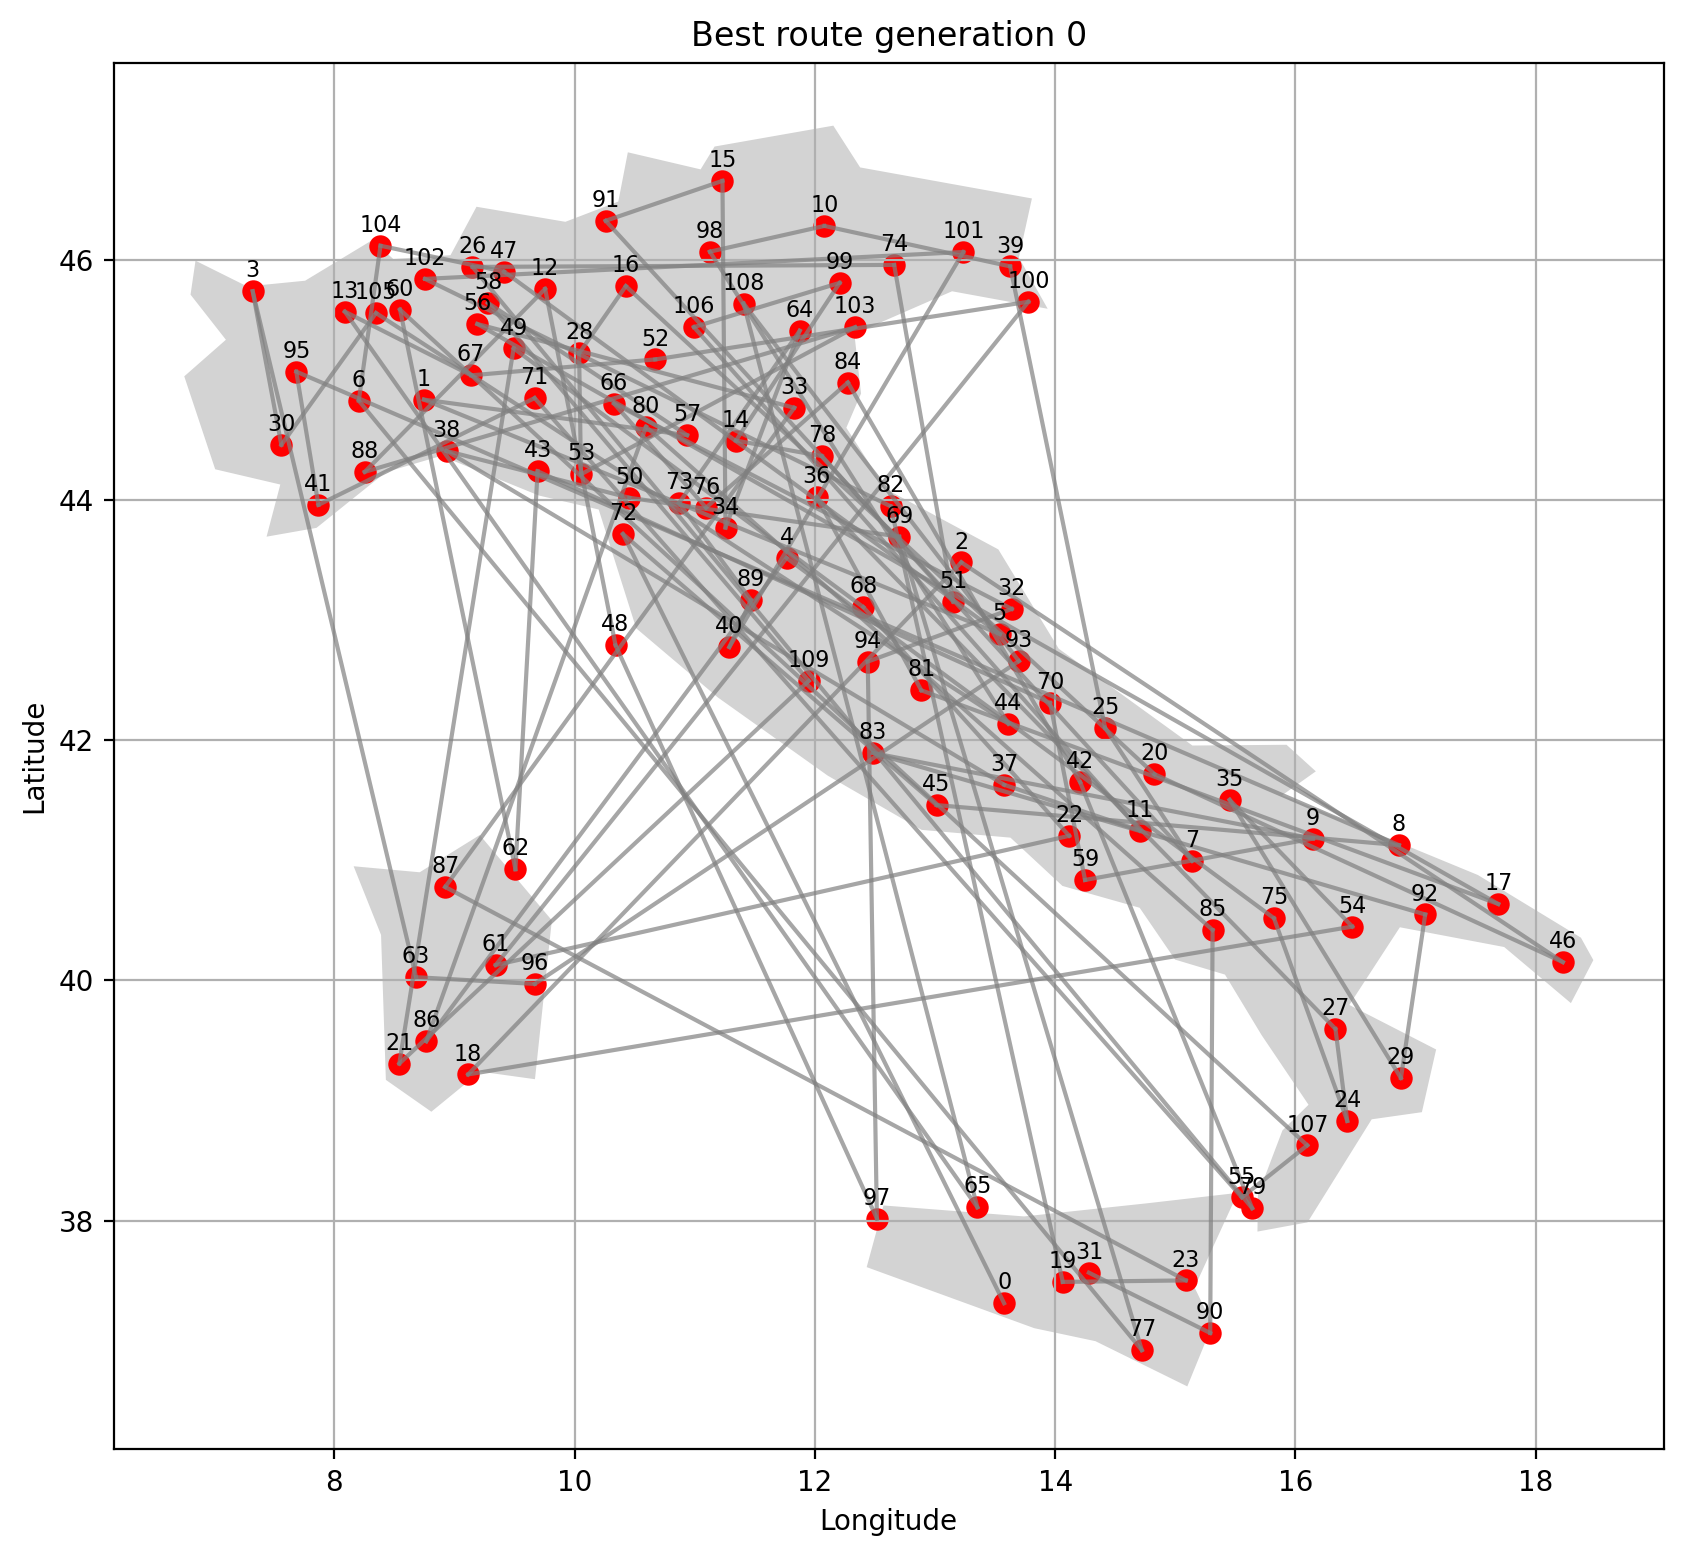

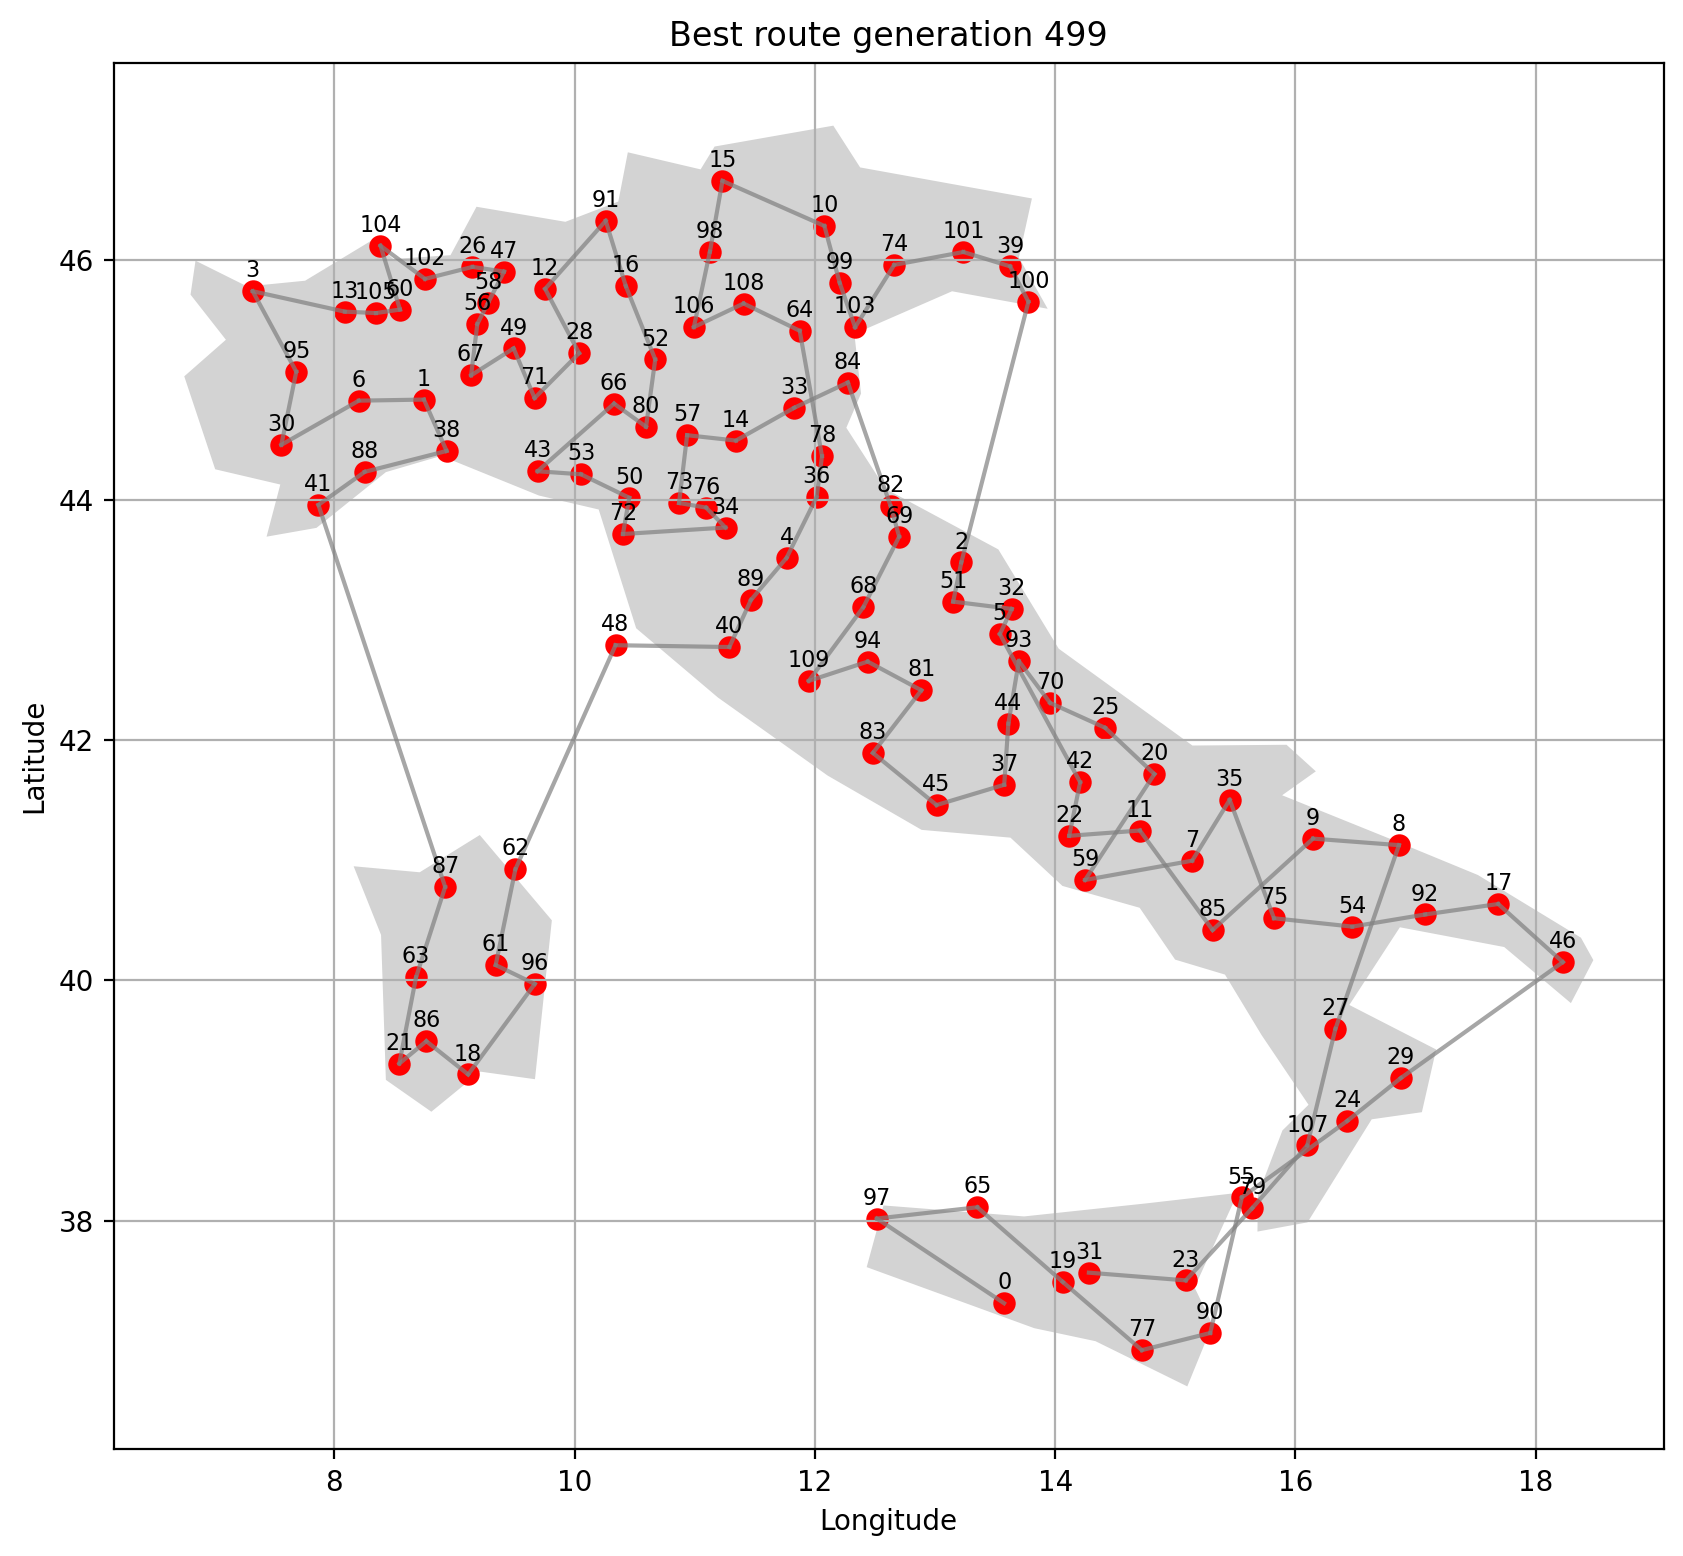

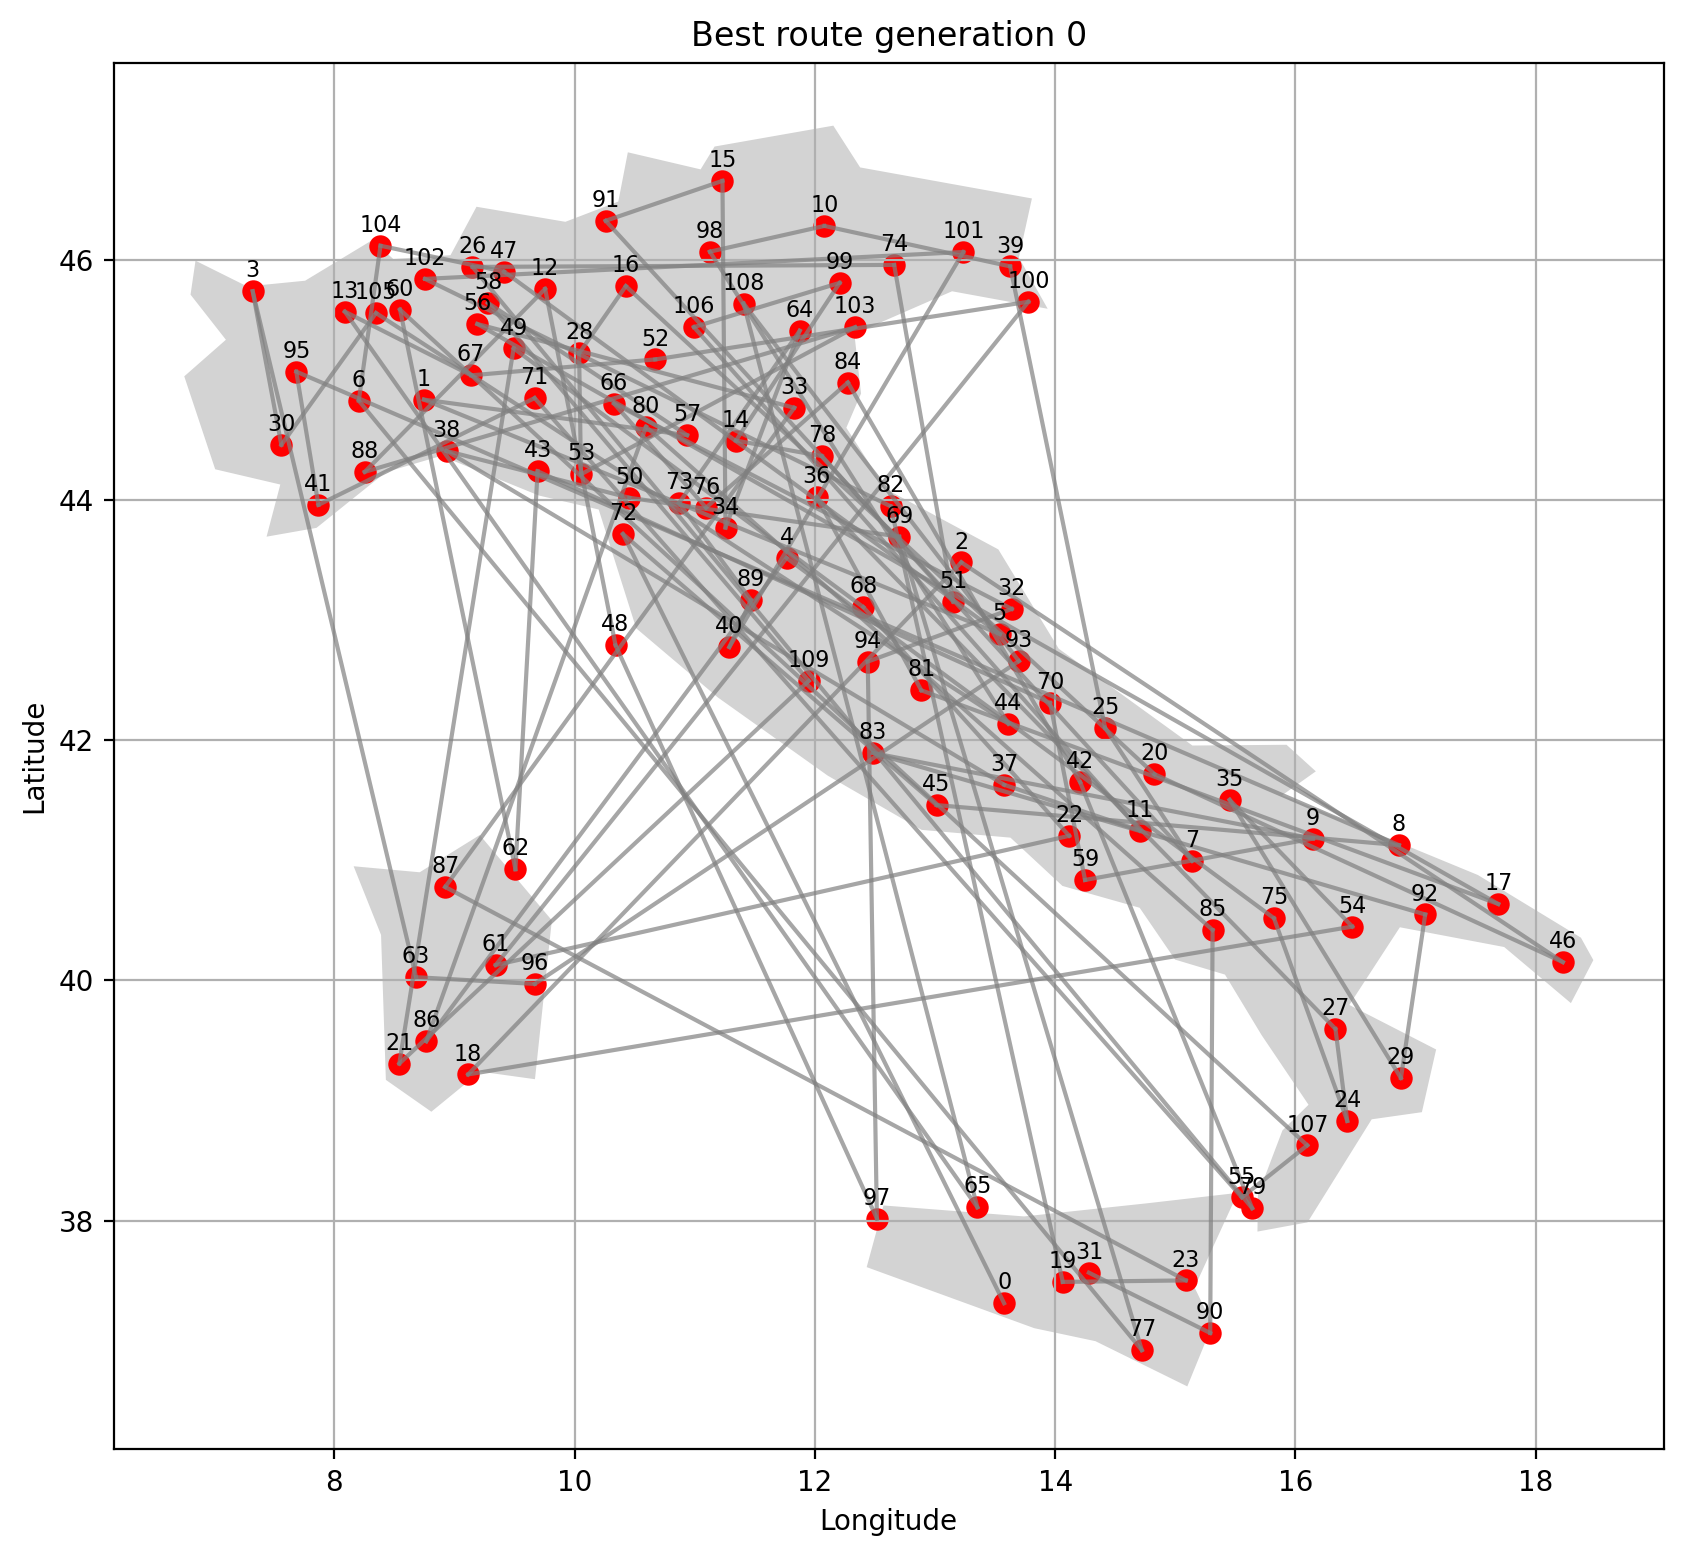

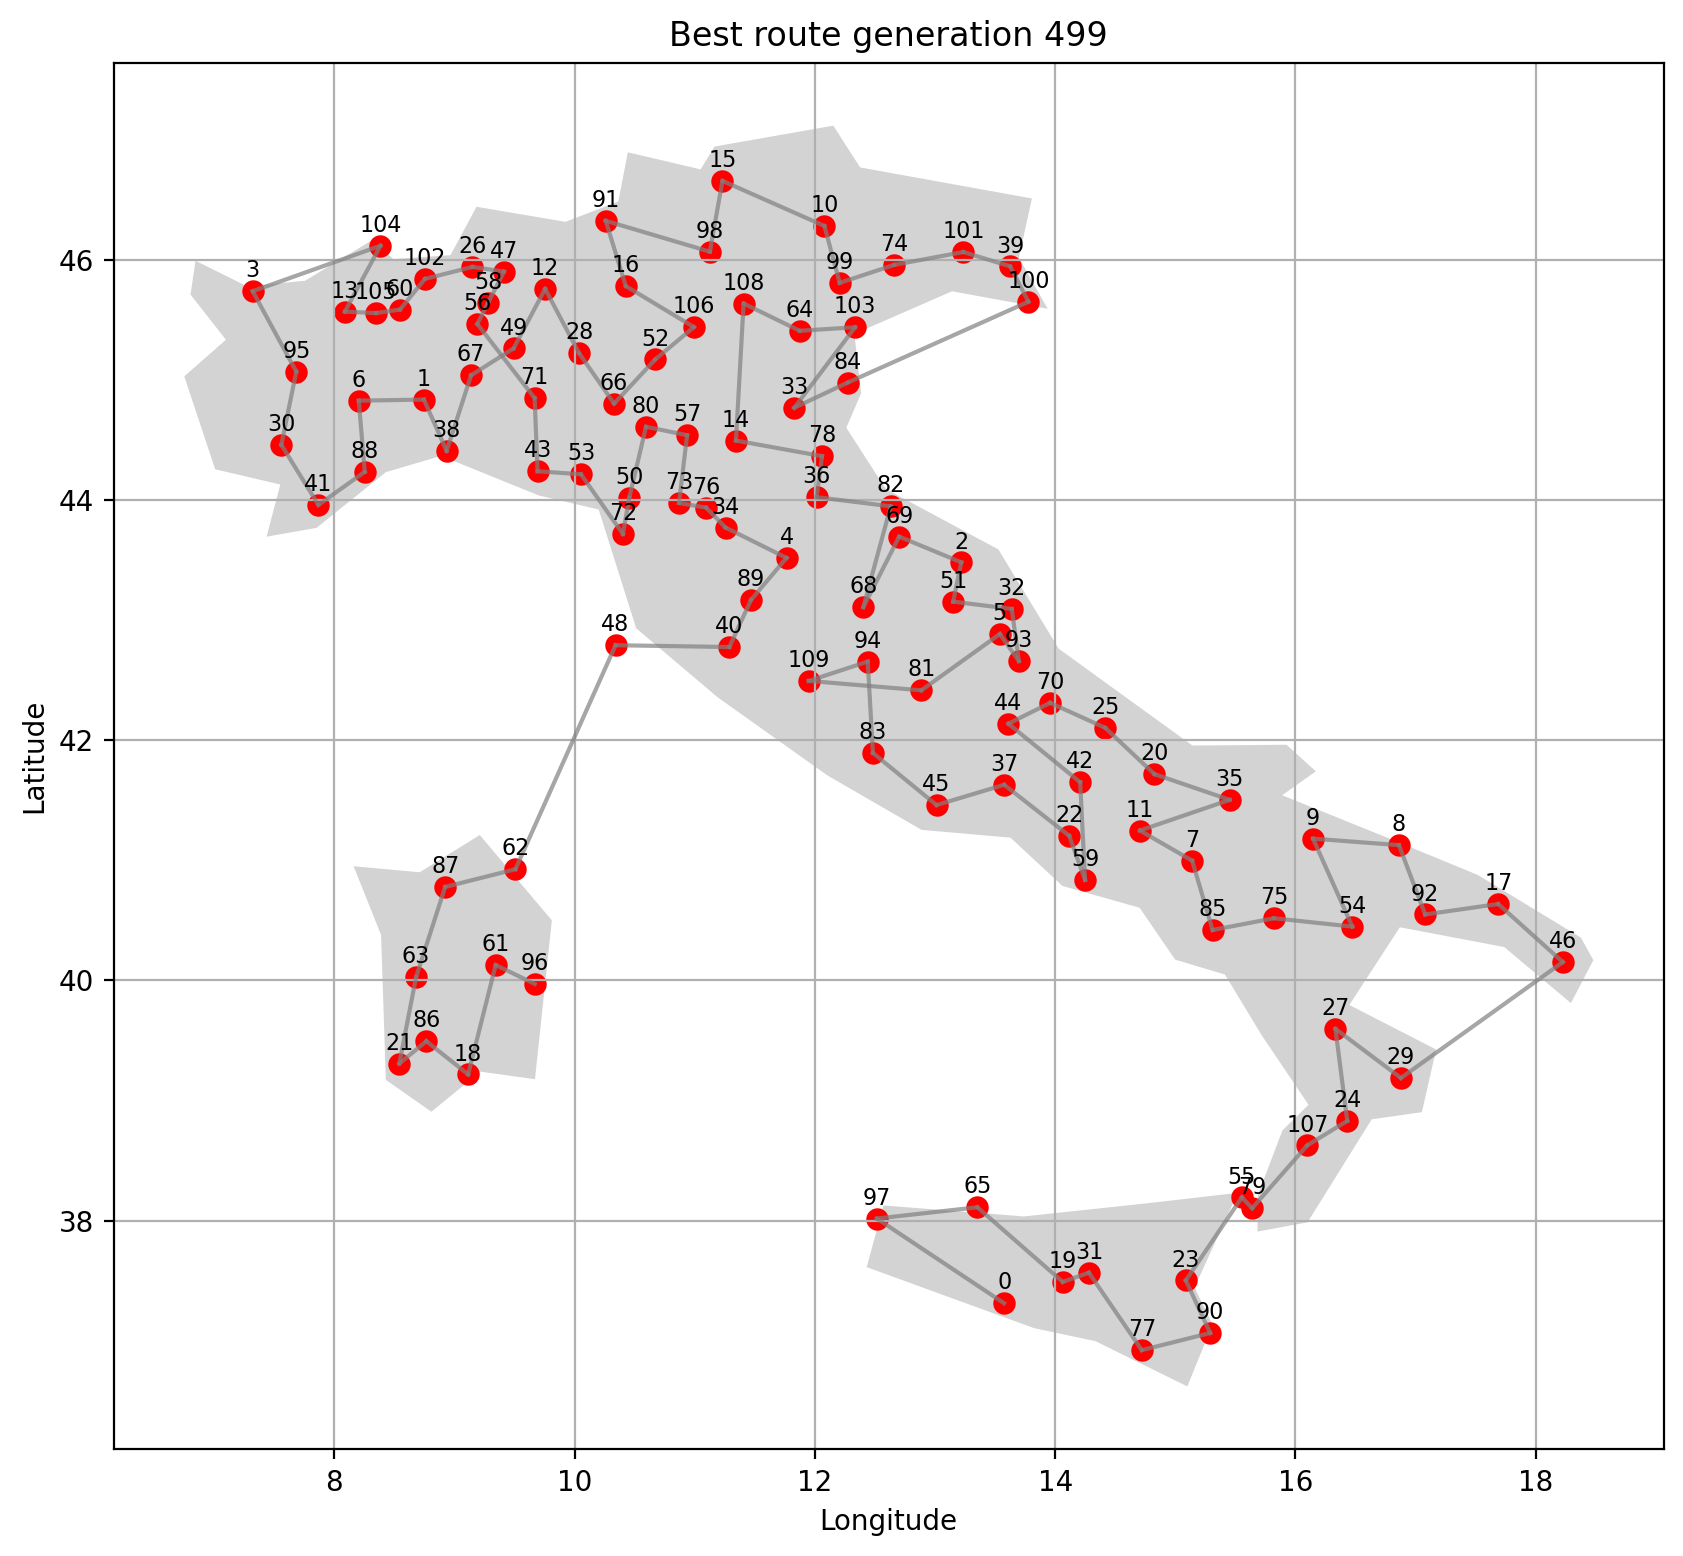

500

In [85]:
generations = open_data_generations ("Provinces", "yes", 0, 0)
open_data_generations ("Provinces", "yes", generations-1, 0)

open_data_generations ("Provinces", "no", 0, 0)
open_data_generations ("Provinces", "no", generations-1, 0)